In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from utils import device
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import torch

/opt/conda/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [3]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

In [4]:
from utils import ImageDataset, ConvResNet, init_dataloader, channel_binary_mask, \
    checkerboard_binary_mask, AffineCouplingLayer, RealNVP, Scale, FinalScale
import torch
from torch.distributions.normal import Normal
from math import log
device = torch.device(device)

In [5]:
batch_size = 64
num_resnet_blocks = 16
num_scale_blocks = 2
sample_path = "./plots_2scale_resnet_16"

In [6]:
# celebA_train_dataset = torchvision.datasets.CelebA(root="/home/ext_amin_unity3d_com/real_nvp_data_celebA",
#                                                    split="train",
#                                                    download=True,
#                                                    transform=transforms.Compose([transforms.ToTensor()])
#                                                    )

In [7]:
# celebA_train_dataloader = torch.utils.data.DataLoader(celebA_train_dataset, batch_size=64)

In [8]:
lsun_train_dataset = ImageDataset(root_dir="/home/ext_amin_unity3d_com/real_nvp_data/train")
lsun_train_dataloader = init_dataloader(lsun_train_dataset, batch_size=batch_size)

In [9]:
dataset = lsun_train_dataset
dataloader = lsun_train_dataloader

In [10]:
tmp_input = torch.ones(5, 3, 32, 32).to(device)
tmp_input_split = torch.ones(5, 6, 16, 16).to(device)

In [11]:
scale = Scale().to(device=device)
forwarded_scale, _  = scale(tmp_input)
reversed_scale = scale.reverse(forwarded_scale)
print(torch.norm(tmp_input - reversed_scale))

tensor(nan, device='cuda:0', grad_fn=<NormBackward1>)


In [12]:
final_scale = FinalScale().to(device)
forwarded_fs, _ = final_scale(tmp_input_split)
reversed_fs = final_scale.reverse(forwarded_fs)
print(torch.norm(tmp_input_split - reversed_fs))

tensor(0.3460, device='cuda:0', grad_fn=<NormBackward1>)


In [13]:
def save_plot(n_row, n_column, generated_image, epoch, path):
    fig, ax = plt.subplots(n_row, n_column, squeeze=True)
    fig.subplots_adjust(wspace=.02, hspace=.02)
    for i in range(0, n_row):
        for j in range (0, n_column):
            ax[i, j].axis("off")
            image = (generated_image[i, j].permute([1, 2, 0]).detach().cpu().numpy())
            _ = ax[i, j].imshow(image, aspect="auto")
    plt.suptitle(f"generated_plot epoch {epoch}")
    fig.savefig(f"{path}/generated_image_epoch_{epoch}.png")

In [14]:
realnvp = RealNVP(num_resnet_blocks=num_resnet_blocks,
                  num_scales=num_scale_blocks).to(device)
print(f"number of parameters in the model {sum([p.numel() for p in realnvp.parameters()])}")
optimizer = torch.optim.Adam(lr=1e-3, params=realnvp.parameters())

# bs = 2
# forwarded = realnvp(torch.arange(1, bs*3 * 32 * 32 + 1).reshape(bs*1, 3, 32, 32).to(device))
# forwarded[0].shape
# n_row, n_column = 5, 5
# generated_image = realnvp.sample(n_row * n_column).view(n_row, n_column, 3, 32, 32)
# save_plot(n_row, n_column, generated_image, epoch=1000, path="./bs_samples")


number of parameters in the model 1607410


epcoh 0, batch 0, loss 14.679190635681152
epcoh 0, batch 99, loss 7.462108612060547
epcoh 0, batch 198, loss 6.795938014984131
epcoh 0, batch 297, loss 6.2314300537109375
epcoh 0, batch 396, loss 5.912237644195557
epcoh 0, batch 495, loss 5.536167144775391
epcoh 0, batch 594, loss 5.18190336227417
epcoh 0, batch 693, loss 4.966821670532227
epcoh 0, batch 792, loss 4.740237236022949
epcoh 0, batch 891, loss 4.669872283935547
epoch 0, loss: 6.028347969055176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

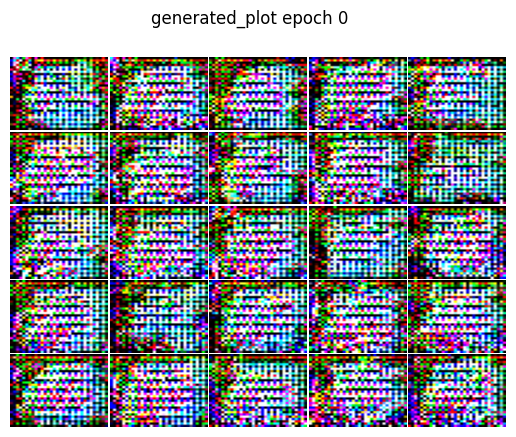

In [15]:
# plotting
n_row, n_column = 5, 5

epochs = 1

loss_per_epoch = []
for e in range(0, epochs):
    loss_per_bath = []
    for i, data in enumerate(dataloader):
        image_batch = data.to(device)
        optimizer.zero_grad()
        z, loss = realnvp(image_batch)
        loss.backward()
        optimizer.step()
        if i % 99 == 0:
            print(f"epcoh {e}, batch {i}, loss {loss}")
        loss_per_bath.append(loss)
    
    epoch_loss = torch.Tensor(loss_per_bath).mean()
    print(f"epoch {e}, loss: {epoch_loss}")
    realnvp.eval()
    
    generated_image = realnvp.sample(n_row * n_column).view(n_row, n_column, 3, 32, 32)
    save_plot(n_row=n_row, n_column=n_column, path=sample_path, generated_image=generated_image, epoch=e)
    realnvp.train()
    
    loss_per_epoch.append(epoch_loss)